In [42]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt

In [43]:
local_path = os.getcwd()

In [44]:
(ds_train, ds_test), ds_info=tfds.load(
    
    name='cats_vs_dogs',
    data_dir=os.path.join(local_path, 'data'),
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True, #입력 파일을 섞을지 여부
    with_info=True      #빌더와 관련된 정보포함 유무
)

In [45]:
#feature 정보를 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [46]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [47]:
# 데이터 클래스 개수 확인
print(ds_info.features["label"].num_classes)

2


In [48]:
#데이터 클래스 이름 확인
print(ds_info.features["label"].names)

['cat', 'dog']


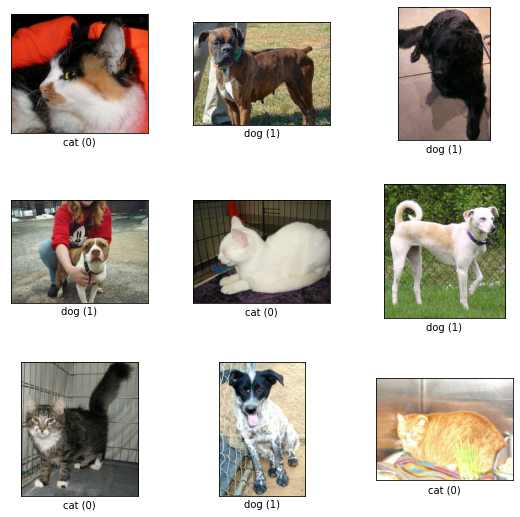

In [49]:
#이미지 확인
fig = tfds.show_examples(ds_train, ds_info)
#fig = tfds.show_examples(ds_test, ds_info)

## Data Normalization
- 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
- 0-255 사이의 값으로 가지는데, 이를 255로 나누어주면 0-1.0 사이의 값으로 변환
- (x - x_min) / (x_max - x_min)
- scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄인다.
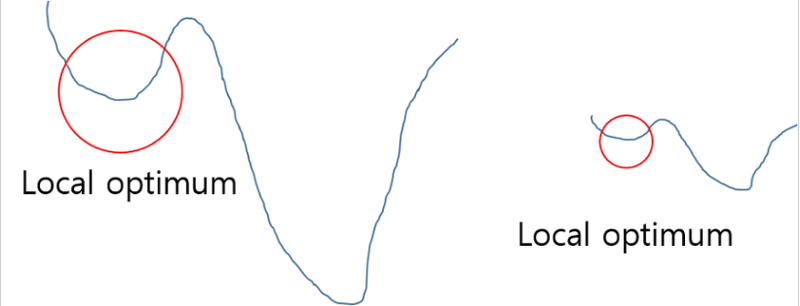

In [50]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [51]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [52]:
BATCH_SIZE = 64

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 블럭 구성하기
- 반복되는 부분을 줄여서 하이퍼파라미터 변경, 모델 구조 변경할 때 쉽게 바꿀 수 있도록 만들어 놓는 것이 필요  
- 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block)
- 예시 ResNet  
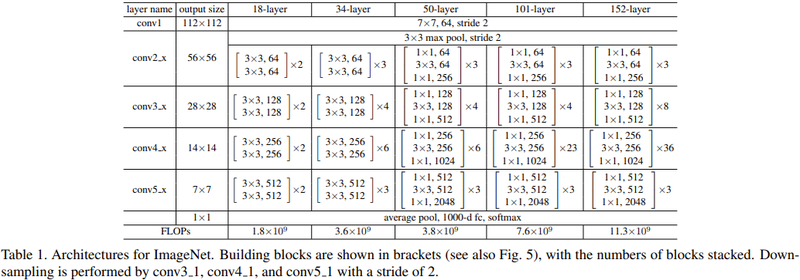

In [53]:
def residual_block(input_layer, channels=[64,64], kernel_sizes=[3,3], stride=1, residual_f=True, b_num=0, layer=0):
#  print(input_layer.shape)
  x = input_layer
  if residual_f:
    if stride==1 and (len(channels)==2):
      downsample = lambda x: x
    else:
      downsample = tf.keras.Sequential()
      downsample.add(tf.keras.layers.Conv2D(filters=channels[-1],
                                            kernel_size=(1,1),
                                            strides=stride))
      downsample.add(tf.keras.layers.BatchNormalization())    
    residual = downsample(x)

  for i, (channel, kernel_size) in enumerate(zip(channels, kernel_sizes)):
#    print("Conv channel={}, kernel_size={}".format(channel, kernel_size))
    if i == 0:
      x = keras.layers.Conv2D(
          filters=channel,
          kernel_size=kernel_size,
          strides=stride,
          padding='same',
          name='conv{}_block{}_{}_conv'.format(b_num, layer, i+1)
      )(x)
    else:
      x = keras.layers.Conv2D(
          filters=channel,
          kernel_size=kernel_size,
          padding='same',
          name='conv{}_block{}_{}_conv'.format(b_num, layer, i+1)
      )(x)
#    print("BatchNormalization")
    x = tf.keras.layers.BatchNormalization(
        name='conv{}_block{}_{}_bn'.format(b_num, layer, i+1))(x)
    if (len(channels)-1) != i:
#      print("relu")
      x = tf.nn.relu(x, name='conv{}_block{}_{}_relu'.format(b_num, layer, i+1))
#  print("add")
#  print(residual.shape, x.shape)
  if residual_f:
    return tf.nn.relu(
        tf.keras.layers.add([residual, x], name='conv{}_block{}_add'.format(b_num, layer)),
        name='conv{}_block{}_relu'.format(b_num, layer))
  else:
    return tf.nn.relu(
        x,
        name='conv{}_block{}_relu'.format(b_num, layer))
#  else:
#    return x

In [54]:
"""
input_layer = keras.layers.Input(shape=(224,224,3))

x = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")(input_layer)
x = tf.keras.layers.BatchNormalization()(x)

#conv2_x
x = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")(x)
for i in range(3):
  x = residual_block(x, channels=[64,64], kernel_sizes=[3,3])

#conv3_x
for i in range(4):
  if i ==0:
    x = residual_block(x, channels=[128,128], kernel_sizes=[3,3], stride=2)
  else:
    x = residual_block(x, channels=[128,128], kernel_sizes=[3,3])

#conv4_x
for i in range(6):
  if i ==0:
    x = residual_block(x, channels=[256,256], kernel_sizes=[3,3], stride=2)
  else:
    x = residual_block(x, channels=[256,256], kernel_sizes=[3,3])

#conv5_x
for i in range(3):
  if i ==0:
    x = residual_block(x, channels=[512,512], kernel_sizes=[3,3], stride=2)
  else:
    x = residual_block(x, channels=[512,512], kernel_sizes=[3,3])

#fc
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(x)

model = keras.Model(
      inputs=input_layer,
      outputs=x
)
model.summary()
"""

'\ninput_layer = keras.layers.Input(shape=(224,224,3))\n\nx = tf.keras.layers.Conv2D(filters=64,\n                                            kernel_size=(7, 7),\n                                            strides=2,\n                                            padding="same")(input_layer)\nx = tf.keras.layers.BatchNormalization()(x)\n\n#conv2_x\nx = tf.keras.layers.MaxPool2D(pool_size=(3, 3),\n                                               strides=2,\n                                               padding="same")(x)\nfor i in range(3):\n  x = residual_block(x, channels=[64,64], kernel_sizes=[3,3])\n\n#conv3_x\nfor i in range(4):\n  if i ==0:\n    x = residual_block(x, channels=[128,128], kernel_sizes=[3,3], stride=2)\n  else:\n    x = residual_block(x, channels=[128,128], kernel_sizes=[3,3])\n\n#conv4_x\nfor i in range(6):\n  if i ==0:\n    x = residual_block(x, channels=[256,256], kernel_sizes=[3,3], stride=2)\n  else:\n    x = residual_block(x, channels=[256,256], kernel_sizes=[3,3

In [55]:
def build_resnet(input_shape=(224,224,3),
                 blocks=[3,4,6,3],
                 Channels=[[64,64], [128,128], [256,256], [512,512]],
                 Kernel_sizes=[[3,3], [3,3], [3,3], [3,3]],
                 num_classes=2,
                 residual=True):
  assert len(blocks) == len(Channels) == len(Kernel_sizes) == 4
  
  input_layer = keras.layers.Input(shape=input_shape)


  #conv1
  x = tf.keras.layers.Conv2D(filters=64,
                             kernel_size=(7, 7),
                             strides=2,
                             padding="same",
                             name='conv1_conv')(input_layer)
  x = tf.keras.layers.BatchNormalization(name='conv1_bn')(x)  
  x = tf.nn.relu(x, name='conv1_relu')

  #conv2_x
  x = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                strides=2,
                                padding="same",
                                name='pool1_pool')(x)
  for i in range(blocks[0]):
    x = residual_block(x, channels=Channels[0], kernel_sizes=Kernel_sizes[0], residual_f=residual, b_num=2, layer=i+1)

  #conv3_x
  for i in range(blocks[1]):
    if i ==0:
      x = residual_block(x, channels=Channels[1], kernel_sizes=Kernel_sizes[1], stride=2, residual_f=residual, b_num=3, layer=i+1)
    else:
      x = residual_block(x, channels=Channels[1], kernel_sizes=Kernel_sizes[1], residual_f=residual, b_num=3, layer=i+1)

  #conv4_x
  for i in range(blocks[2]):
    if i ==0:
      x = residual_block(x, channels=Channels[2], kernel_sizes=Kernel_sizes[2], stride=2, residual_f=residual, b_num=4, layer=i+1)
    else:
      x = residual_block(x, channels=Channels[2], kernel_sizes=Kernel_sizes[2], residual_f=residual, b_num=4, layer=i+1)

  #conv5_x
  for i in range(blocks[3]):
    if i ==0:
      x = residual_block(x, channels=Channels[3], kernel_sizes=Kernel_sizes[2], stride=2, residual_f=residual, b_num=5, layer=i+1)
    else:
      x = residual_block(x, channels=Channels[3], kernel_sizes=Kernel_sizes[2], residual_f=residual, b_num=5, layer=i+1)

  #fc
  x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
  if num_classes == 2:
    x = tf.keras.layers.Dense(
        units=num_classes-1, 
        activation=tf.keras.activations.sigmoid,
        name='fc')(x)
  else:
    x = tf.keras.layers.Dense(
        units=num_classes, 
        activation=tf.keras.activations.softmax,
        name='fc')(x)


  model = keras.Model(
      inputs = input_layer,
      outputs = x
  )
  return model

In [56]:
resnet_34 = build_resnet()
resnet_34.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                          

In [57]:
resnet_34_plain = build_resnet(residual=False)
resnet_34_plain.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_conv (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 64)     256       
 n)                                                              
                                                                 
 tf.nn.relu_439 (TFOpLambda)  (None, 112, 112, 64)     0         
                                                                 
 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 conv2_block1_1_conv (Conv2D  (None, 56, 56, 64)       36928     
 )                                                        

In [58]:
resnet_50 = build_resnet(input_shape=(224,224,3),
                        blocks=[3,4,6,3],
                        Channels=[[64,64,256], [128,128,512], [256,256,1024], [512,512,2048]],
                        Kernel_sizes=[[1,3,1], [1,3,1], [1,3,1], [1,3,1]],
                        num_classes=2)
resnet_50.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                          

In [59]:
resnet_50_plain = build_resnet(input_shape=(224,224,3),
                        blocks=[3,4,6,3],
                        Channels=[[64,64,256], [128,128,512], [256,256,1024], [512,512,2048]],
                        Kernel_sizes=[[1,3,1], [1,3,1], [1,3,1], [1,3,1]],
                        num_classes=2,
                        residual=False)
resnet_50_plain.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_conv (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 64)     256       
 n)                                                              
                                                                 
 tf.nn.relu_521 (TFOpLambda)  (None, 112, 112, 64)     0         
                                                                 
 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
                                                                 
 conv2_block1_1_conv (Conv2D  (None, 56, 56, 64)       4160      
 )                                                        

In [60]:
EPOCH = 15

In [61]:
print(ds_info.splits['train'].num_examples)

23262


In [62]:
resnet_34.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
  metrics=['accuracy']
)

history_34 = resnet_34.fit(
  ds_train,
  steps_per_epoch=int((ds_info.splits['train'].num_examples*0.8)/BATCH_SIZE),
  validation_steps=int((ds_info.splits['train'].num_examples*0.2)/BATCH_SIZE),
  epochs=EPOCH,
  validation_data=ds_test,
  verbose=1,
  use_multiprocessing=True
)

Epoch 1/15
290/290 [==============================] - 133s 400ms/step - loss: 0.6345 - accuracy: 0.6322 - val_loss: 1.0011 - val_accuracy: 0.4895
Epoch 2/15
290/290 [==============================] - 116s 401ms/step - loss: 0.5787 - accuracy: 0.6964 - val_loss: 0.8726 - val_accuracy: 0.5503
Epoch 3/15
290/290 [==============================] - 116s 401ms/step - loss: 0.5310 - accuracy: 0.7295 - val_loss: 0.6340 - val_accuracy: 0.6699
Epoch 4/15
290/290 [==============================] - 116s 401ms/step - loss: 0.4839 - accuracy: 0.7617 - val_loss: 0.7353 - val_accuracy: 0.6068
Epoch 5/15
290/290 [==============================] - 116s 400ms/step - loss: 0.4274 - accuracy: 0.8014 - val_loss: 0.6298 - val_accuracy: 0.7177
Epoch 6/15
290/290 [==============================] - 116s 399ms/step - loss: 0.3855 - accuracy: 0.8267 - val_loss: 0.5224 - val_accuracy: 0.7693
Epoch 7/15
290/290 [==============================] - 116s 400ms/step - loss: 0.3221 - accuracy: 0.8593 - val_loss: 0.4768 -

In [63]:
resnet_34_plain.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
  metrics=['accuracy']
)

history_34_plain = resnet_34_plain.fit(
  ds_train,
  steps_per_epoch=int((ds_info.splits['train'].num_examples*0.8)/BATCH_SIZE),
  validation_steps=int((ds_info.splits['train'].num_examples*0.2)/BATCH_SIZE),
  epochs=EPOCH,
  validation_data=ds_test,
  verbose=1,
  use_multiprocessing=True
)

Epoch 1/15
290/290 [==============================] - 128s 383ms/step - loss: 0.6851 - accuracy: 0.5665 - val_loss: 0.9808 - val_accuracy: 0.4902
Epoch 2/15
290/290 [==============================] - 111s 381ms/step - loss: 0.6796 - accuracy: 0.5702 - val_loss: 0.6864 - val_accuracy: 0.5697
Epoch 3/15
290/290 [==============================] - 110s 381ms/step - loss: 0.6749 - accuracy: 0.5849 - val_loss: 0.7829 - val_accuracy: 0.4882
Epoch 4/15
290/290 [==============================] - 111s 383ms/step - loss: 0.6641 - accuracy: 0.5972 - val_loss: 0.7087 - val_accuracy: 0.5289
Epoch 5/15
290/290 [==============================] - 111s 382ms/step - loss: 0.6535 - accuracy: 0.6156 - val_loss: 0.8458 - val_accuracy: 0.5253
Epoch 6/15
290/290 [==============================] - 111s 382ms/step - loss: 0.6491 - accuracy: 0.6153 - val_loss: 1.2780 - val_accuracy: 0.5182
Epoch 7/15
290/290 [==============================] - 110s 381ms/step - loss: 0.6380 - accuracy: 0.6339 - val_loss: 0.7235 -

In [64]:
resnet_50.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
  metrics=['accuracy']
)

history_50 = resnet_50.fit(
  ds_train,
  steps_per_epoch=int((ds_info.splits['train'].num_examples*0.8)/BATCH_SIZE),
  validation_steps=int((ds_info.splits['train'].num_examples*0.2)/BATCH_SIZE),
  epochs=EPOCH,
  validation_data=ds_test,
  verbose=1,
  use_multiprocessing=True
)

Epoch 1/15
290/290 [==============================] - 339s 1s/step - loss: 0.6955 - accuracy: 0.5465 - val_loss: 0.8993 - val_accuracy: 0.4813
Epoch 2/15
290/290 [==============================] - 316s 1s/step - loss: 0.6855 - accuracy: 0.5693 - val_loss: 0.6980 - val_accuracy: 0.5510
Epoch 3/15
290/290 [==============================] - 316s 1s/step - loss: 0.6776 - accuracy: 0.5897 - val_loss: 0.8264 - val_accuracy: 0.5173
Epoch 4/15
290/290 [==============================] - 316s 1s/step - loss: 0.6714 - accuracy: 0.5975 - val_loss: 0.7166 - val_accuracy: 0.5575
Epoch 5/15
290/290 [==============================] - 317s 1s/step - loss: 0.6664 - accuracy: 0.6042 - val_loss: 0.8179 - val_accuracy: 0.5278
Epoch 6/15
290/290 [==============================] - 316s 1s/step - loss: 0.6563 - accuracy: 0.6174 - val_loss: 0.9542 - val_accuracy: 0.5111
Epoch 7/15
290/290 [==============================] - 316s 1s/step - loss: 0.6463 - accuracy: 0.6312 - val_loss: 0.9340 - val_accuracy: 0.5534

In [65]:
resnet_50_plain.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
  metrics=['accuracy']
)

history_50_plain = resnet_50_plain.fit(
  ds_train,
  steps_per_epoch=int((ds_info.splits['train'].num_examples*0.8)/BATCH_SIZE),
  validation_steps=int((ds_info.splits['train'].num_examples*0.2)/BATCH_SIZE),
  epochs=EPOCH,
  validation_data=ds_test,
  verbose=1,
  use_multiprocessing=True
)

Epoch 1/15
290/290 [==============================] - 193s 599ms/step - loss: 0.6961 - accuracy: 0.5344 - val_loss: 0.7414 - val_accuracy: 0.4918
Epoch 2/15
290/290 [==============================] - 172s 595ms/step - loss: 0.6921 - accuracy: 0.5501 - val_loss: 0.7085 - val_accuracy: 0.5170
Epoch 3/15
290/290 [==============================] - 173s 597ms/step - loss: 0.6921 - accuracy: 0.5459 - val_loss: 0.7533 - val_accuracy: 0.5328
Epoch 4/15
290/290 [==============================] - 173s 596ms/step - loss: 0.6928 - accuracy: 0.5409 - val_loss: 0.8001 - val_accuracy: 0.5188
Epoch 5/15
290/290 [==============================] - 173s 597ms/step - loss: 0.6926 - accuracy: 0.5430 - val_loss: 0.6992 - val_accuracy: 0.5356
Epoch 6/15
290/290 [==============================] - 173s 595ms/step - loss: 0.6908 - accuracy: 0.5472 - val_loss: 0.7047 - val_accuracy: 0.5475
Epoch 7/15
290/290 [==============================] - 173s 597ms/step - loss: 0.6846 - accuracy: 0.5651 - val_loss: 0.7104 -

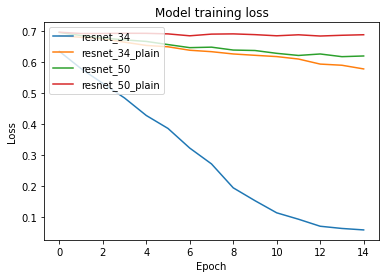

In [66]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'])
plt.plot(history_34_plain.history['loss'])
plt.plot(history_50.history['loss'])
plt.plot(history_50_plain.history['loss'])

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34','resnet_34_plain', 'resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

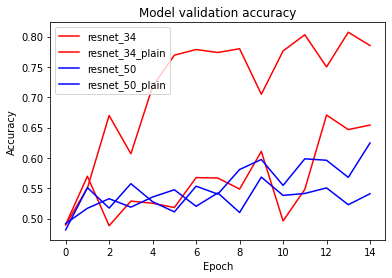

In [67]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_50_plain.history['val_accuracy'], 'b')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34','resnet_34_plain', 'resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()

## 결론
1. resnet layer를 보면 맞게 구현한 것 같은데 resnet-50의 acc, loss은 왜 저럴까?  
  예상
  - 모델 구현 잘못  
  - optimizer
  - 데이터에 비해 너무 큰 모델
2. 확실히 resnet-34, resnet-34_plain을 보면 residual block이 효과가 있는 것 같다.